In [277]:
from sklearn.metrics import mean_squared_error
from math import sqrt # rms = sqrt(mean_squared_error(y_true, y_predicted))
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# linear regression models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,BayesianRidge
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 6
# cross val, k-folds
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
import re
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
%matplotlib inline
#df = pd.read_csv('bcp.csv')
k = pd.read_csv('it.csv')
k.head()

,Unnamed: 0,1 Month,1 Year,10 Year,3 Month,3 Year,5 Year,6 Month,Area,Benchmark_Price,Month,Price,Property Type,Year
0,0,0.70%,-2.90%,NaN,1.50%,2.90%,3.60%,-0.70%,Lower Mainland,539100.0,April,152.2,Residential / Composite,2013
1,1,0.70%,-3.90%,NaN,1.60%,3.20%,5.40%,-1.10%,Greater Vancouver,597300.0,April,156.6,Residential / Composite,2013
2,2,-0.20%,-7.80%,NaN,-0.20%,-8.50%,-9.80%,-2.50%,Bowen Island,571500.0,April,123.9,Residential / Composite,2013
3,3,0.70%,-2.40%,NaN,3.30%,2.40%,5.00%,-0.50%,Burnaby East,560800.0,April,154.8,Residential / Composite,2013
4,4,-0.40%,-3.20%,NaN,1.00%,2.40%,2.40%,0.10%,Burnaby North,508900.0,April,152.0,Residential / Composite,2013


In [278]:
k.Benchmark_Price=k.Benchmark_Price.astype(float)
#minimum na values so ok to fill na
k['Month']=k.Month.fillna(k.Month.mode())

In [279]:
#convert month to numeric
meta_dict = { 'January':int, 'February':int, 'March':int, 'April':int,'May':int,'June':int,'July':int,'August':int,'September':int,'October':int,'November':int,'December':int}
my_dict = {'January':"1", 'February':"2", 'March':"3", 'April':"4",'May':"5",'June':"6",'July':"7",'August':"8",'September':"9",'October':"10",'November':"11",'December':"12"}  # adding a string key for the demo
d= { k:meta_dict.get(k,str)(v) for k,v in my_dict.items()}
k.Month = k.Month.map(d)

In [280]:
k.Month=k['Month'].fillna(0).astype(int)
k.Month.isnull().sum()

0

In [281]:
#change data type to int for parsing
k.Month=k.Month.astype(int)
k.to_csv('mydata.csv')

In [282]:
#parse to date time
def parse(x):
    return datetime.strptime(x, '%Y %M')
dataset = pd.read_csv('mydata.csv',  parse_dates = [['Year', 'Month']], index_col=0, date_parser=parse)

In [283]:
# manually specify column names
df=dataset[['Area','Benchmark_Price','Property Type']]

In [284]:
#select vancouver east
df_east=df[df['Area']=='Vancouver East']

In [285]:
#select apartment property price
df_east=df_east[df_east['Property Type']=='Apartment']

In [286]:
df_east=df_east[['Benchmark_Price']]

In [287]:
#encoder = LabelEncoder()
#df_east['Area']= encoder.fit_transform(df_east.Area)
df_east.head(3)

,Benchmark_Price
Year_Month,
2013-01-01 00:04:00,305100.0
2013-01-01 00:08:00,304000.0
2013-01-01 00:12:00,308900.0


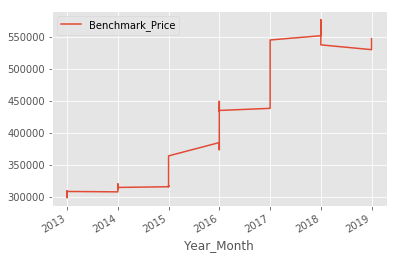

In [288]:
df_east.plot()

In [289]:
df_east.shape

(75, 1)

In [290]:
# frame a sequence as a supervised learning problem
def convert_supervised(df):
    columns = [df.shift(i) for i in range(1, 2)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]),dropout=.2, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [291]:
#convert df to values
#take the difference to make it stationary
raw_values = df_east.values
diff_values = difference(raw_values, 1)
#create a dataframe
df = pd.DataFrame(diff_values)

In [292]:
# transform data to be supervised learning
supervised = convert_supervised(df)
supervised_values = supervised.values
# split data into train and test-sets
#train_size = int(len(supervised_values) * 0.7)
#train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
#scaler, train_scaled, test_scaled = scale(train, test)


In [293]:

from matplotlib import pyplot
np.random.seed()
# fit the model
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
#------------------------------------------------------------------------------------------------ 
# transform the scale of the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)
#reshape train for numpy
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)
#reshape test for numpy
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)
#------------------------------------------------------------------------------------------------
# fit the model

lstm_model = fit_lstm(train_scaled, 1, 30, 4)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Month=1, Predicted=541359.200060, Expected=565300.000000
Month=2, Predicted=569344.932113, Expected=552300.000000
Month=3, Predicted=556174.615309, Expected=568900.000000
Month=4, Predicted=573086.800426, Expected=573800.000000
Month=5, Predicted=578005.445329, Expected=577600.000000
Month=6, Predicted=581750.503957, Expected=575800.000000
Month=7, Predicted=579833.517373, Expected=551400.000000
Month=8, Predicted=554985.864370, Expected=569100.000000
Month=9, Predicted=573198.704123, Expected=575700.000000
Month=10, Predicted=579954.294837, Expected=545200.000000
Month=11, Predicted=548815.464275, Expected=530500.000000
Month=12, Predicted=534150.280058, Expected=547700.000000
Test RMSE: 17801.102


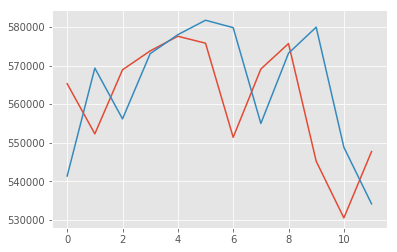

In [294]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [295]:
# last value of our dataset
f = np.array(547)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [296]:
# initial record
initial = train_scaled
train_scaled.shape
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(20):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])



In [297]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

In [298]:
rng = pd.date_range('2017-08-31 00:00:00', periods=20, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.columns = ['Date', 'Price']
kl=prediction.head(20)

In [299]:
kl

,Date,Price
0,2017-08-31,547.546204
1,2017-09-30,547.554199
2,2017-10-31,547.560303
3,2017-11-30,547.562561
4,2017-12-31,547.562927
5,2018-01-31,547.562500
6,2018-02-28,547.561829
7,2018-03-31,547.561096
8,2018-04-30,547.560486
9,2018-05-31,547.559998


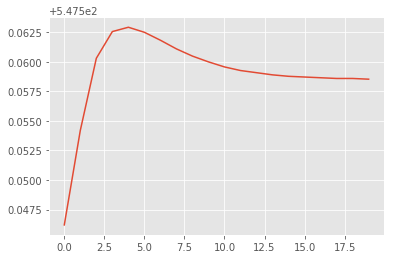

In [300]:
kl.Price.plot()